In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from keras.backend import manual_variable_initialization 

manual_variable_initialization(True)

In [3]:
test_data = pd.read_csv("data/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("data/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("data/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

In [4]:
test_data.head()

,Comment,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [5]:
test_data.shape

(2000, 2)

In [6]:
train_data.shape

(16000, 2)

In [7]:
validation_data.shape

(2000, 2)

In [8]:
# determine lenth of comment
train_data['length'] = [len(comment) for comment in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [9]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

# Data Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

In [11]:
#Representating emotions with int
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

In [12]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [13]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sauga_g\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
vocab_size = 10000
max_len=train_data['length'].max()
max_len

300

In [15]:
def text_prepare(data, column):
    print('Before:')
    print(data.shape)
    stemmer = PorterStemmer()
    corpus = []
    
    for text in data[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        
        text = text.lower()
        text = text.split()
        
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    embeddec_doc = pad_sequences(sequences=one_hot_word,
                              maxlen=max_len,
                              padding="pre")
    print('After:')
    print(data.shape)
    return embeddec_doc

In [16]:
x_train = text_prepare(train_data, "Comment")
x_test = text_prepare(test_data, "Comment")
x_val = text_prepare(validation_data, "Comment")

Before:
(16000, 3)
After:
(16000, 3)
Before:
(2000, 2)
After:
(2000, 2)
Before:
(2000, 2)
After:
(2000, 2)


In [17]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Model Building

In [19]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1500000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [21]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [22]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 88s 347ms/step - loss: 1.4603 - accuracy: 0.4244 - val_loss: 0.9273 - val_accuracy: 0.6965
Epoch 2/10
250/250 [==============================] - 102s 407ms/step - loss: 0.6564 - accuracy: 0.7818 - val_loss: 0.4524 - val_accuracy: 0.8335
Epoch 3/10
250/250 [==============================] - 103s 413ms/step - loss: 0.3353 - accuracy: 0.8884 - val_loss: 0.3602 - val_accuracy: 0.8790
Epoch 4/10
250/250 [==============================] - 100s 400ms/step - loss: 0.2258 - accuracy: 0.9251 - val_loss: 0.3305 - val_accuracy: 0.8870
Epoch 5/10
250/250 [==============================] - 102s 408ms/step - loss: 0.1707 - accuracy: 0.9448 - val_loss: 0.3313 - val_accuracy: 0.8965
Epoch 6/10
250/250 [==============================] - 104s 415ms/step - loss: 0.1339 - accuracy: 0.9555 - val_loss: 0.3591 - val_accuracy: 0.8855


# Evaluation

In [23]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 3s 53ms/step - loss: 0.3783 - accuracy: 0.8725


[0.37831729650497437, 0.8725000023841858]

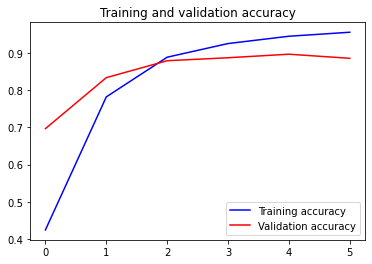

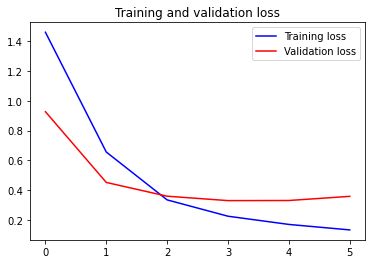

In [24]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Saving model

In [42]:
model.save('model.h5')

# Making Predictions

#### Cleaning provided input

In [26]:
def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

#### Returns dictonary with probability values

In [27]:
def getDict(sentence):
    sentence = sentence_cleaning(sentence)
    labels = lb.inverse_transform([0,1,2,3,4,5])
    final_dir = dict(zip(labels,model.predict(sentence)[0]))
    return final_dir
    
    
    

#### Return Predicted Emotions

In [38]:
def getEmotion(sentence):
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model2.predict(sentence), axis=-1))[0]
    return result

In [39]:
getEmotion('e is really sweet and caring')

'love'